In [1]:
import pandas as pd

insurance = pd.read_csv("insurance.csv")
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [2]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000176E8A877B8>,
      dtype=object)

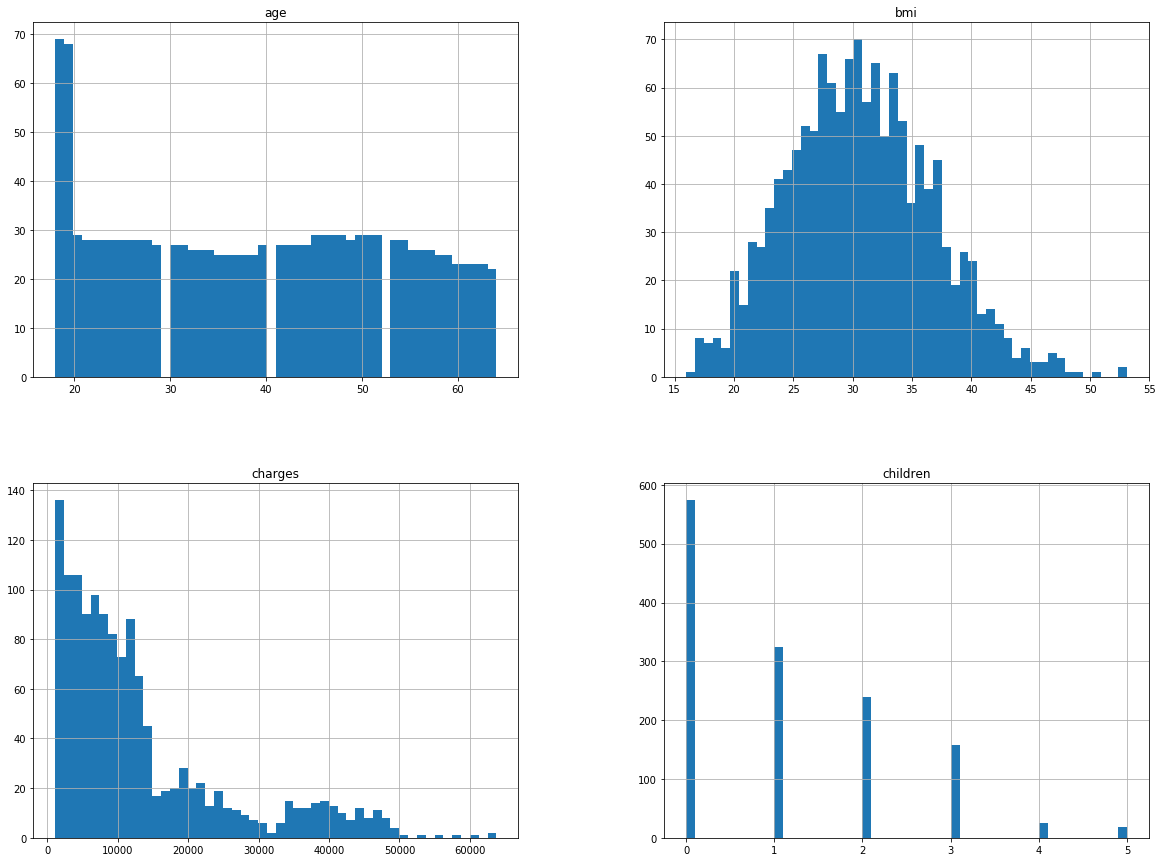

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
insurance.hist(bins=50, figsize=(20,15))

In [4]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [5]:
corr_matrix = insurance.corr()
corr_matrix.head()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


In [6]:
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

In [21]:
insurance = insurance.drop("children", axis = 1)
insurance_to_pip = insurance.copy()
insurance_to_pip = insurance_to_pip.drop("charges", axis = 1)
insurance_to_pip_labels = insurance["charges"].copy()
#insurance = insurance.drop("bmi", axis = 1)

KeyError: "['children'] not found in axis"

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000176E8E1BBE0>,
      dtype=object)

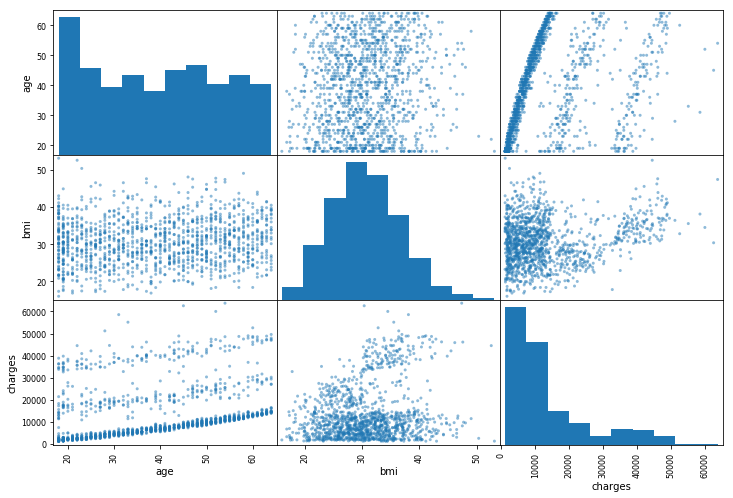

In [8]:
from pandas.plotting import scatter_matrix

attributes = ["age", "bmi", "charges"]
scatter_matrix(insurance[attributes], figsize=(12, 8))

In [9]:
insurance_cat_region = insurance["region"]
insurance_cat_region_encoded, insurance_cat_region_categories = insurance_cat_region.factorize()
insurance_cat_region_encoded[:10]

array([0, 1, 1, 2, 2, 1, 1, 2, 3, 2], dtype=int64)

In [10]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
insurance_cat_region_1hot = encoder.fit_transform(insurance_cat_region)
insurance_cat_region_1hot

array([[0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

In [11]:
insurance_cat_smoker = insurance["smoker"]
insurance_cat_smoker_1hot = encoder.fit_transform(insurance_cat_smoker)
insurance_cat_smoker_1hot

array([[1],
       [0],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [12]:
insurance_cat_sex = insurance["sex"]
insurance_cat_sex_1hot = encoder.fit_transform(insurance_cat_sex)
insurance_cat_sex_1hot

array([[0],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [13]:
insurance_num = insurance.copy()
insurance_num = insurance_num.drop("sex", axis = 1)
insurance_num = insurance_num.drop("region", axis = 1)
insurance_num = insurance_num.drop("smoker", axis = 1)
insurance_num_data = insurance_num.copy()
#insurance_num = pd.concat((pd.DataFrame(insurance_num),pd.DataFrame(insurance_cat_smoker_1hot),
#                           pd.DataFrame(insurance_cat_region_1hot), pd.DataFrame(insurance_cat_sex_1hot)),axis=1)
insurance_num = pd.concat((pd.DataFrame(insurance_num),pd.DataFrame(insurance_cat_smoker_1hot)),axis=1)
insurance_num.head()

,age,bmi,charges,0
0,19,27.900,16884.92400,1
1,18,33.770,1725.55230,0
2,28,33.000,4449.46200,0
3,33,22.705,21984.47061,0
4,32,28.880,3866.85520,0


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

num_attribs = list(insurance_num_data)
cat_attribs = ["smoker"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', CustomLabelBinarizer()),
    ])

preparation_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [20]:
insurance_pre = preparation_pipeline.fit_transform(insurance_to_pip)
insurance_pre

array([[-1.43876426, -0.45332   ,  0.2985838 ,  1.        ],
       [-1.50996545,  0.5096211 , -0.95368917,  0.        ],
       [-0.79795355,  0.38330685, -0.72867467,  0.        ],
       ...,
       [-1.50996545,  1.0148781 , -0.96159623,  0.        ],
       [-1.29636188, -0.79781341, -0.93036151,  0.        ],
       [ 1.55168573, -0.26138796,  1.31105347,  1.        ]])

In [ ]:
insurance_prepared = insurance_num.drop("charges", axis = 1)
insurance_labels = insurance_num["charges"].copy()

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(insurance_num, test_size = 0.2, random_state = 42)

In [ ]:
train_data = train_set.drop("charges", axis = 1)
train_labels = train_set["charges"].copy()
train_data.shape

In [ ]:
test_data = test_set.drop("charges", axis = 1)
test_labels = test_set["charges"].copy()

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(insurance_prepared, insurance_labels)

In [ ]:
from sklearn.metrics import mean_squared_error
insurance_predictions = lin_reg.predict(insurance_prepared)
lin_mse = mean_squared_error(insurance_labels, insurance_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(train_data, train_labels)
housing_predictions = tree_reg.predict(train_data)
tree_mse = mean_squared_error(train_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse